## Rigid registration example

In [37]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import time
import logging

from opentps.core.processing.registration.registrationRigid import RegistrationRigid
from opentps.core.examples.syntheticData import *
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D
from opentps.core.processing.imageProcessing.imageTransform3D import rotateData, translateData


### Generate synthetic images

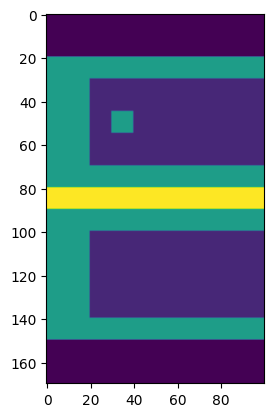

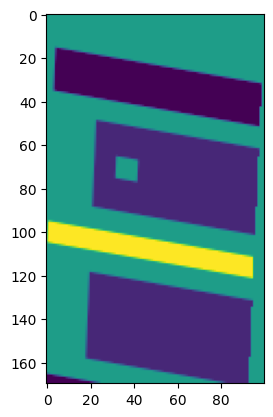

In [38]:
fixed = createSynthetic3DCT()
moving = copy.copy(fixed)

translation = np.array([15, 0, 10])
rotation = np.array([0, 5, 0])

translateData(moving, translation, outputBox='same')
rotateData(moving, rotation, outputBox='same')
plt.imshow(fixed.imageArray[:,95,:])
plt.show()
plt.imshow(moving.imageArray[:,95,:])


###  Perform the Rigid registration

In [39]:
start_time = time.time()
reg = RegistrationRigid(fixed, moving)
transform = reg.compute()

processing_time = time.time() - start_time
print('Registration processing time was', processing_time, '\n')
print('Translation', transform.getTranslation())
print('Rotation in deg', transform.getRotationAngles(inDegrees=True), '\n')

## Two ways of getting the deformed moving image
#deformedImage = reg.deformed
deformedImage = transform.deformImage(moving)

## Resample it to the same grid as the fixed image
resampledOnFixedGrid = resampleImage3DOnImage3D(deformedImage, fixedImage=fixed, fillValue=-1000)

Final metric value: 19945.711049659527
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 31 iterations. Current step (9.53674e-07) is less than minimum step (1e-06).
itk::simple::CompositeTransform
 CompositeTransform (00000216254B1ED0)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 1996504
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0000021624B1B6D0)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 1996494
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.995794 -0.000422025 0.0916217 
       0.000452553 1 -0.000312418 
       -0.0916215 0.000352568 0.995794 
     Offset: [14.9122, -0.000670789, 1.13981]
     Center: [84.5, 84.5, 99]
     Translation: [23.5916, 0.00662771, -6.98882]
     Inverse: 
       0.995794 0.

### Compute the difference between the 2 images and check results of the registration

In [61]:
#IMAGE DIFFERENCE
diff_before = fixed.copy()
diff_before._imageArray = fixed.imageArray - moving.imageArray
print(diff_before.imageArray.shape)
diff_after = fixed.copy()
diff_after._imageArray = fixed.imageArray - resampledOnFixedGrid.imageArray
print(diff_after.imageArray.shape)
# CHECK RESULTS
diff_before_sum = abs(diff_before.imageArray).sum()
diff_after_sum = abs(diff_after.imageArray).sum()
assert diff_before_sum - diff_after_sum > 0, f"Image difference is larger after registration"

(170, 170, 100)
(170, 170, 100)


### Plot results

(170, 100)


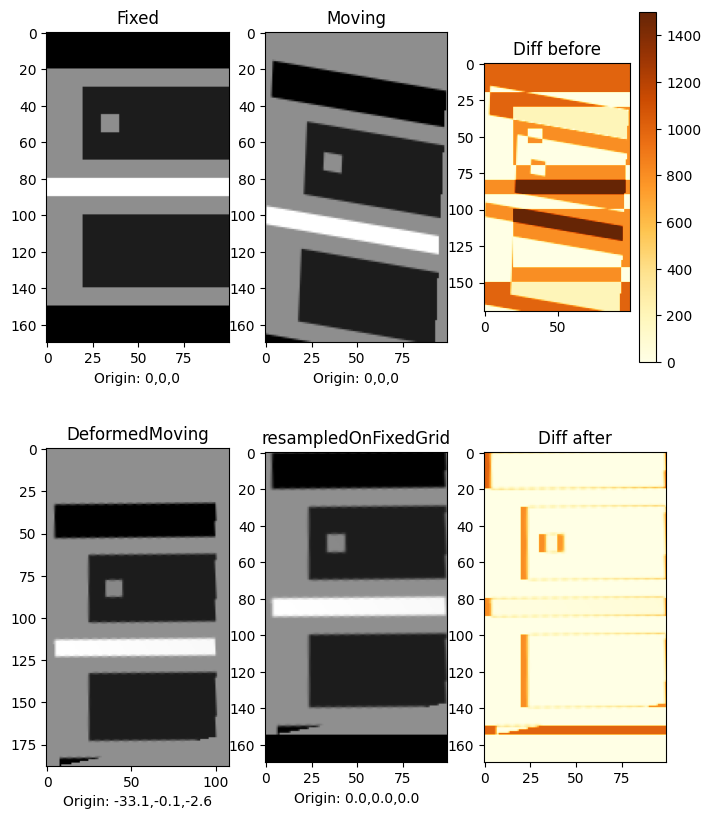

In [66]:
y_slice = 95
fig, ax = plt.subplots(2, 3,figsize=(8,10))
ax[0, 0].imshow(fixed.imageArray[:, y_slice, :],cmap='gray')
ax[0, 0].set_title('Fixed')
ax[0, 0].set_xlabel('Origin: '+f'{fixed.origin[0]}'+','+f'{fixed.origin[1]}'+','+f'{fixed.origin[2]}')
ax[0, 1].imshow(moving.imageArray[:, y_slice, :],cmap='gray')
ax[0, 1].set_title('Moving')
ax[0, 1].set_xlabel('Origin: ' + f'{moving.origin[0]}' + ',' + f'{moving.origin[1]}' + ',' + f'{moving.origin[2]}')
diffBef = ax[0, 2].imshow(abs(diff_before.imageArray[:, y_slice, :]), vmin=0, vmax=1500,cmap='YlOrBr')
ax[0, 2].set_title('Diff before')
fig.colorbar(diffBef, ax=ax[0, 2])
ax[1, 0].imshow(deformedImage.imageArray[:, y_slice, :],cmap='gray')
ax[1, 0].set_title('DeformedMoving')
ax[1, 0].set_xlabel('Origin: ' + f'{deformedImage.origin[0]:.1f}' + ',' + f'{deformedImage.origin[1]:.1f}' + ',' + f'{deformedImage.origin[2]:.1f}')
ax[1, 1].imshow(resampledOnFixedGrid.imageArray[:, y_slice, :],cmap='gray')
ax[1, 1].set_title('resampledOnFixedGrid')
ax[1, 1].set_xlabel('Origin: ' + f'{resampledOnFixedGrid.origin[0]:.1f}' + ',' + f'{resampledOnFixedGrid.origin[1]:.1f}' + ',' + f'{resampledOnFixedGrid.origin[2]:.1f}')
diffAft = ax[1, 2].imshow(abs(diff_after.imageArray[:, y_slice, :]), vmin=0, vmax=1500,cmap='YlOrBr')
ax[1, 2].set_title('Diff after')
#fig.colorbar(diffAft, ax=ax[1, 2])
plt.show()